In [1]:
big.data.path <- Sys.getenv("ACADEMYR_BIG_DATA_PATH")
data.path <- "../data"
output.path <- "./output/xdf"
if(!file.exists(output.path)) dir.create(output.path, recursive = TRUE)
sample.data.dir <- rxGetOption("sampleDataDir")

Let's compare the performance of HPA functions with their open-source R couterparts:
  - `rxLinMod` vs `lm`
  - `rxLogit` vs `glm`
  - `rxGlm` vs `glm`
  - `rxSummary` vs `dplyr`

We will read the `airline.csv` data set and load it into R as a `data.frame` (since open-source R functions do not work on XDF files, we won't be using XDF for these tests).

In [2]:
airline.csv <- file.path(sample.data.dir, "AirlineDemoSmall.csv")

colInfo <- list(
  DayOfWeek = list(
    type = "factor",
    levels = c("Monday", "Tuesday", "Wednesday",
               "Thursday", "Friday", "Saturday", "Sunday"))
)

airline.df <- rxImport(inData = airline.csv, # no outFile means we get a data.frame
                       colInfo = colInfo,
                       missingValueString = "M")

dim(airline.df)

Rows Read: 500000, Total Rows Processed: 500000, Total Chunk Time: 1.116 seconds
Rows Read: 100000, Total Rows Processed: 600000, Total Chunk Time: 0.407 seconds 


[1] 600000      3

## `rxLinMod` vs `lm`

In [3]:
model <- lm(ArrDelay ~ DayOfWeek, data = airline.df)
summary(model)

model <- rxLinMod(ArrDelay ~ DayOfWeek, data = airline.df, dropFirst = TRUE)
summary(model)


Call:
lm(formula = ArrDelay ~ DayOfWeek, data = airline.df)

Residuals:
    Min      1Q  Median      3Q     Max 
 -96.33  -20.03  -11.03    4.71 1475.20 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         12.0256     0.1317  91.323  < 2e-16 ***
DayOfWeekTuesday    -0.7318     0.1992  -3.674 0.000239 ***
DayOfWeekWednesday  -1.8691     0.1971  -9.481  < 2e-16 ***
DayOfWeekThursday   -3.3676     0.1955 -17.226  < 2e-16 ***
DayOfWeekFriday      2.7787     0.1948  14.262  < 2e-16 ***
DayOfWeekSaturday   -0.1503     0.1925  -0.781 0.434947    
DayOfWeekSunday     -1.6938     0.1872  -9.049  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 40.65 on 582621 degrees of freedom
  (17372 observations deleted due to missingness)
Multiple R-squared:  0.001869,	Adjusted R-squared:  0.001858 
F-statistic: 181.8 on 6 and 582621 DF,  p-value: < 2.2e-16


Rows Read: 600000, Total Rows Processed: 600000, Total Chunk Time: 0.016 seconds 
Computation time: 0.031 seconds.


Call:
rxLinMod(formula = ArrDelay ~ DayOfWeek, data = airline.df, dropFirst = TRUE)

Linear Regression Results for: ArrDelay ~ DayOfWeek
Data: airline.df
Dependent variable(s): ArrDelay
Total independent variables: 8 (Including number dropped: 1)
Number of valid observations: 582628
Number of missing observations: 17372 
 
Coefficients: (1 not defined because of singularities)
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          12.0256     0.1317  91.323 2.22e-16 ***
DayOfWeek=Monday     Dropped    Dropped Dropped  Dropped    
DayOfWeek=Tuesday    -0.7318     0.1992  -3.674 0.000239 ***
DayOfWeek=Wednesday  -1.8691     0.1971  -9.481 2.22e-16 ***
DayOfWeek=Thursday   -3.3676     0.1955 -17.226 2.22e-16 ***
DayOfWeek=Friday      2.7787     0.1948  14.262 2.22e-16 ***
DayOfWeek=Saturday   -0.1503     0.1925  -0.781 0.434947    
DayOfWeek=Sunday     -1.6938     0.1872  -9.049 2.22e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Res

In [5]:
library(microbenchmark)
print(microbenchmark(
  lm(ArrDelay ~ DayOfWeek, data = airline.df),
  rxLinMod(ArrDelay ~ DayOfWeek, data = airline.df, dropFirst = TRUE, reportProgress = 0),
  times = 30
))

Warning message:
: package 'microbenchmark' was built under R version 3.2.5

Unit: milliseconds
                                                                                         expr
                                                  lm(ArrDelay ~ DayOfWeek, data = airline.df)
 rxLinMod(ArrDelay ~ DayOfWeek, data = airline.df, dropFirst = TRUE,      reportProgress = 0)
      min        lq     mean   median        uq       max neval
 930.7913 1169.6999 1266.172 1250.946 1392.1187 1591.7678    30
  40.6278   43.0192   44.675   44.912   45.9528   49.6263    30


## `rxLogit` vs `glm`

In [7]:
parallel <- function() rxLogit(ArrDelay > 10 ~ DayOfWeek, data = airline.df, dropFirst = TRUE, reportProgress = 0)
sequentl <- function() glm(ArrDelay > 10 ~ DayOfWeek, data = airline.df, family = binomial(link = 'logit'))

print(microbenchmark(
  parallel(),
  sequentl(),
  times = 10
))

Unit: milliseconds
       expr       min        lq      mean    median        uq       max neval
 parallel()  309.5624  315.4324  332.5582  333.1512  344.3868  358.7938    10
 sequentl() 4136.6018 4304.9022 4512.4936 4354.6661 4598.3590 5701.2073    10


## `rxSummary` vs `dplyr`

In [6]:
revo_sum <- function() rxSummary(ArrDelay ~ F(DayOfWeek), data = airline.df, reportProgress = 0)

library(dplyr)

dplyrsum <- function() {
  airline.df %>%
    group_by(DayOfWeek) %>%
    summarise(
      Means = mean(ArrDelay, na.rm = TRUE),
      StdDev = sd(ArrDelay, na.rm = TRUE),
      Min = min(ArrDelay, na.rm = TRUE),
      Max = max(ArrDelay, na.rm = TRUE),
      ValidObs = sum(!is.na(ArrDelay))
    )
}

print(microbenchmark(
  revo_sum(),
  dplyrsum(),
  times = 100
))

Warning message:
: package 'dplyr' was built under R version 3.2.5
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Unit: milliseconds
       expr     min       lq     mean  median      uq      max neval
 revo_sum() 37.9547 41.36360 42.20402 41.9075 42.5204  65.2575   100
 dplyrsum() 54.3791 57.17465 59.63282 57.8872 58.7173 103.0335   100


## `rxGlm` vs `glm` on small data set: `glm` wins

In [8]:
library(robust)
data(breslow.dat, package = "robust")
dim(breslow.dat)

parallel <- function() rxGlm(sumY ~ Base + Age + Trt, dropFirst = TRUE, data = breslow.dat, family = poisson(), reportProgress = 0)
sequentl <- function() glm(sumY ~ Base + Age + Trt, data = breslow.dat, family = poisson())

# smaller data set means parallel algorithm is not necessarily faster
print(microbenchmark(
  parallel(),
  sequentl(),
  times = 10
))

Warning message:
: package 'robust' was built under R version 3.2.5Loading required package: fit.models
Warning message:
: package 'fit.models' was built under R version 3.2.5Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: robustbase
Warning message:
: package 'robustbase' was built under R version 3.2.5Loading required package: rrcov
Warning message:
: package 'rrcov' was built under R version 3.2.5Scalable Robust Estimators with High Breakdown Point (version 1.3-11)



[1] 59 12

Unit: milliseconds
       expr      min       lq      mean   median       uq      max neval
 parallel() 131.2236 133.1992 136.72790 135.5893 140.8126 143.8693    10
 sequentl()   3.0929   3.5432   3.73767   3.7775   4.0314   4.0949    10


## `rxGlm` vs `glm` on large data set: `rxGlm` wins

In [9]:
# we blow up the size of the data 3000 fold
breslow.big <- do.call(rbind, lapply(1:3000, function(i) breslow.dat))
dim(breslow.big)

parallel <- function() rxGlm(sumY ~ Base + Age + Trt, dropFirst = TRUE, data = breslow.big, family = poisson(), reportProgress = 0)
sequentl <- function() glm(sumY ~ Base + Age + Trt, data = breslow.big, family = poisson())

# smaller data set means parallel algorithm is not necessarily faster
print(microbenchmark(
  parallel(),
  sequentl(),
  times = 10
))

rm(breslow.big)

[1] 177000     12

Unit: milliseconds
       expr      min        lq      mean    median        uq       max neval
 parallel()  239.926  245.9475  254.3495  252.6901  262.5401  266.5225    10
 sequentl() 1562.181 1603.4385 1830.5127 1770.3475 1943.9905 2310.7595    10


## comparing `RxLocalParallel` with `RxLocalSeq`

In [10]:
rxSetComputeContext(RxLocalParallel())
rxOptions(numCoresToUse = 12)

rxExec(sqrt, rxElemArg(1:4))
# rxElemArg allows you to pass different arguments to each worker
rxExec(sqrt, 1:4, timesToRun = 4)
# timesToRun calculates the square roots of the entire sequence 1:4 four times

[[1]]
[1] 1

[[2]]
[1] 1.414214

[[3]]
[1] 1.732051

[[4]]
[1] 2

[[1]]
[1] 1.000000 1.414214 1.732051 2.000000

[[2]]
[1] 1.000000 1.414214 1.732051 2.000000

[[3]]
[1] 1.000000 1.414214 1.732051 2.000000

[[4]]
[1] 1.000000 1.414214 1.732051 2.000000

In [12]:
nsize <- 10^5
system.time(rnorm(nsize))

rxSetComputeContext(RxLocalSeq())
system.time(rxExec(function(i) rnorm(nsize), rxElemArg(1:4)))

rxSetComputeContext(RxLocalParallel())
system.time(rxExec(function(i) rnorm(nsize), rxElemArg(1:4), execObjects = "nsize"))

   user  system elapsed 
   0.01    0.00    0.02 

   user  system elapsed 
   0.03    0.00    0.03 

   user  system elapsed 
   0.01    0.02    2.57 

In [13]:
compare.runtimes <- function(nsize, nproc) {
  cat(sprintf("size = %s \n", formatC(nsize, format = "d", big.mark = ",")))
  st1 <- system.time(rnorm(nsize))
  
  rxSetComputeContext(RxLocalSeq())
  st2 <- system.time(rxExec(function(i) rnorm(nsize), rxElemArg(1:nproc)))
  
  rxSetComputeContext(RxLocalParallel())
  st3 <- system.time(rxExec(function(i) rnorm(nsize), rxElemArg(1:nproc), execObjects = c("nsize", "nproc")))
  
  dd <- do.call(rbind, list(st1, st2, st3))
  dd <- as.data.frame(dd)
  dd$test <- c('single test', 'four sequential', 'four parallel')
  dd$factor <- dd$elapsed / lag(dd$elapsed)
  dd[ , c('test', 'elapsed', 'factor')]
}

compare.runtimes(10^4, 16)
compare.runtimes(10^5, 16)
compare.runtimes(10^6, 16)
compare.runtimes(10^7, 16)

size = 10,000 


test elapsed factor
1     single test    0.00     NA
2 four sequential    0.02    Inf
3   four parallel    7.59  379.5

size = 100,000 


test elapsed   factor
1     single test    0.02       NA
2 four sequential    0.17  8.50000
3   four parallel    7.71 45.35294

size = 1,000,000 


test elapsed    factor
1     single test    0.11        NA
2 four sequential    2.22 20.181818
3   four parallel    8.50  3.828829

size = 10,000,000 


test elapsed     factor
1     single test    1.06         NA
2 four sequential   18.36 17.3207547
3   four parallel   12.58  0.6851852

## The mandelbrot example:

A complex number is in the mandelbrot set if the following loop converges: $z_{n+1} = z^2_n + c$ where $z_0 = 0$.


In [17]:
mandelbrot <- function(x0, y0, lim) {
  x <- x0; y <- y0
  iter <- 0
  while (x^2 + y^2 < 4 && iter < lim) {
    xtemp <- x^2 - y^2 + x0
    y <- 2 * x * y + y0
    x <- xtemp
    iter <- iter + 1
  }
  iter
}

mandelbrot(0, 0, 50)
mandelbrot(2, 5, 50)

[1] 50

[1] 0

In [18]:
vmandelbrot <- function(xvec, y0, lim) {
  sapply(xvec, mandelbrot, y0 = y0, lim = lim)
}

vmandelbrot(0:10, 0, 50)

[1] 50  1  0  0  0  0  0  0  0  0  0

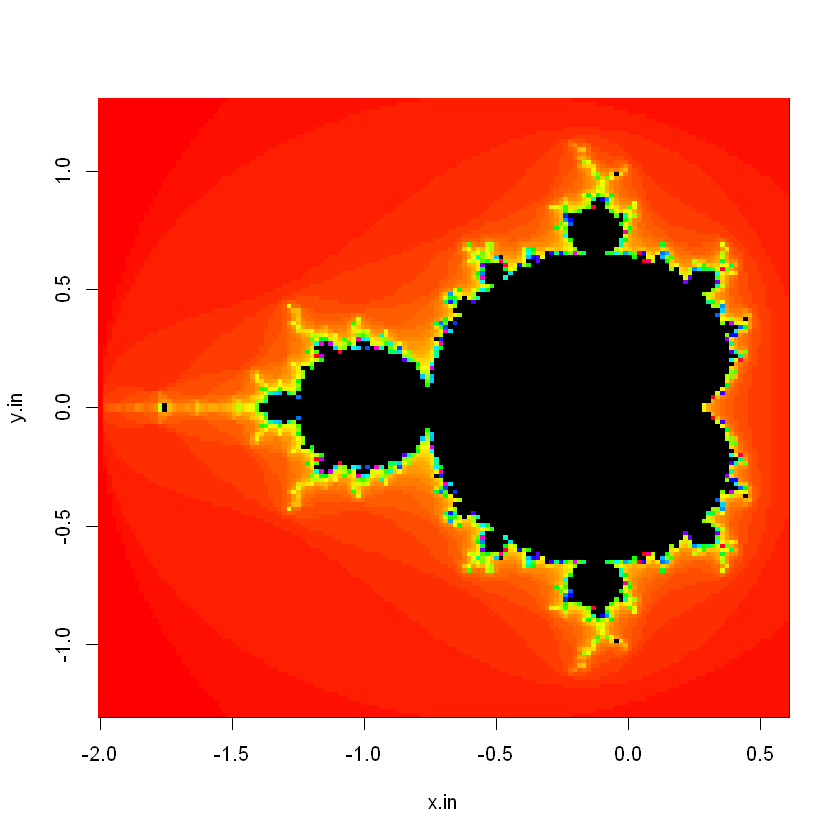

In [19]:
size <- 150
x.in <- seq(-2.0, 0.6, length.out = size)
y.in <- seq(-1.3, 1.3, length.out = size)
m <- 100
z <- rxExec(vmandelbrot, x.in, y0 = rxElemArg(y.in), m, execObjects = "mandelbrot")
z <- matrix(unlist(z), ncol = size) # order the data for the image

image(x.in, y.in, z, col = c(rainbow(m), '#000000'))

## `foreach` vs `RevoScaleR`

In [14]:
library(foreach)
foreach(i = 4:6) %do% sqrt(i) # sequentially
foreach(i = 4:6) %dopar% sqrt(i) # parallel

rxSetComputeContext(RxLocalSeq())
rxExec(sqrt, elemArgs = 4:6) # sequentially

rxSetComputeContext(RxLocalParallel())
rxExec(sqrt, elemArgs = 4:6) # in parallel

[[1]]
[1] 2

[[2]]
[1] 2.236068

[[3]]
[1] 2.44949

Warning message:
: executing %dopar% sequentially: no parallel backend registered

[[1]]
[1] 2

[[2]]
[1] 2.236068

[[3]]
[1] 2.44949

$rxElem1
[1] 2

$rxElem2
[1] 2.236068

$rxElem3
[1] 2.44949

[[1]]
[1] 2

[[2]]
[1] 2.236068

[[3]]
[1] 2.44949

## a parallel backend for `kmeans`

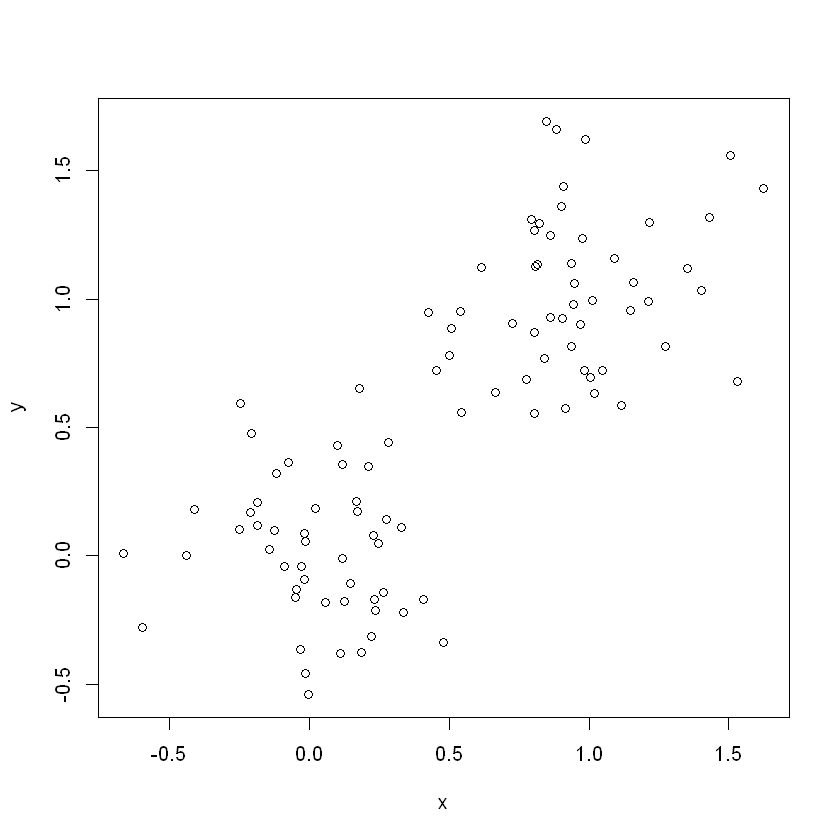

In [22]:
# Create artificial data
set.seed(1)
X <- rbind(
  matrix(rnorm(100, mean = 0, sd = 0.3), ncol = 2),
  matrix(rnorm(100, mean = 1, sd = 0.3), ncol = 2)
)
colnames(X) <- c("x", "y")
plot(X)

In [24]:
kmeans(X, 5)

K-means clustering with 5 clusters of sizes 21, 23, 19, 24, 13

Cluster means:
           x          y
1  1.0494037  0.8429599
2 -0.1392783  0.1815555
3  1.0301705  1.3379236
4  0.1581362 -0.1761590
5  0.5397583  0.7570976

Clustering vector:
  [1] 2 4 2 4 2 2 4 4 2 2 5 4 2 2 4 2 4 5 4 5 4 4 2 2 4 2 4 2 2 4 4 4 2 4 2 2 2
 [38] 4 4 4 4 2 2 2 2 2 4 4 4 4 3 1 5 1 5 1 3 1 1 3 3 1 3 3 1 3 1 1 1 1 3 1 3 1
 [75] 1 1 3 3 3 3 1 3 1 5 3 5 3 1 1 1 5 3 5 3 5 5 3 1 5 5

Within cluster sum of squares by cluster:
[1] 1.1825508 2.0092312 1.8691311 1.2816507 0.8608439
 (between_SS / total_SS =  88.2 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

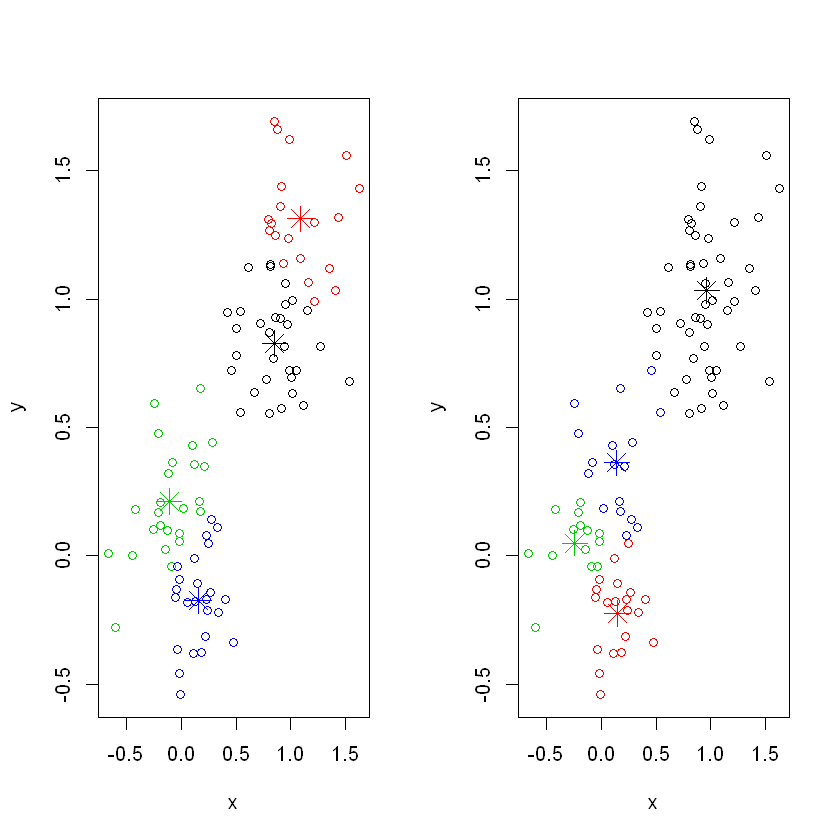

In [26]:
clusterPlot <- function(x, n = 4, nstart = 1){
  cl <- kmeans(x, n, nstart = nstart)
  plot(x, col = cl$cluster)
  points(cl$centers, col = 1:n, pch = 8, cex = 2)
}

par(mfrow=c(1, 2))
clusterPlot(X)
clusterPlot(X)
par(mfrow=c(1, 1))

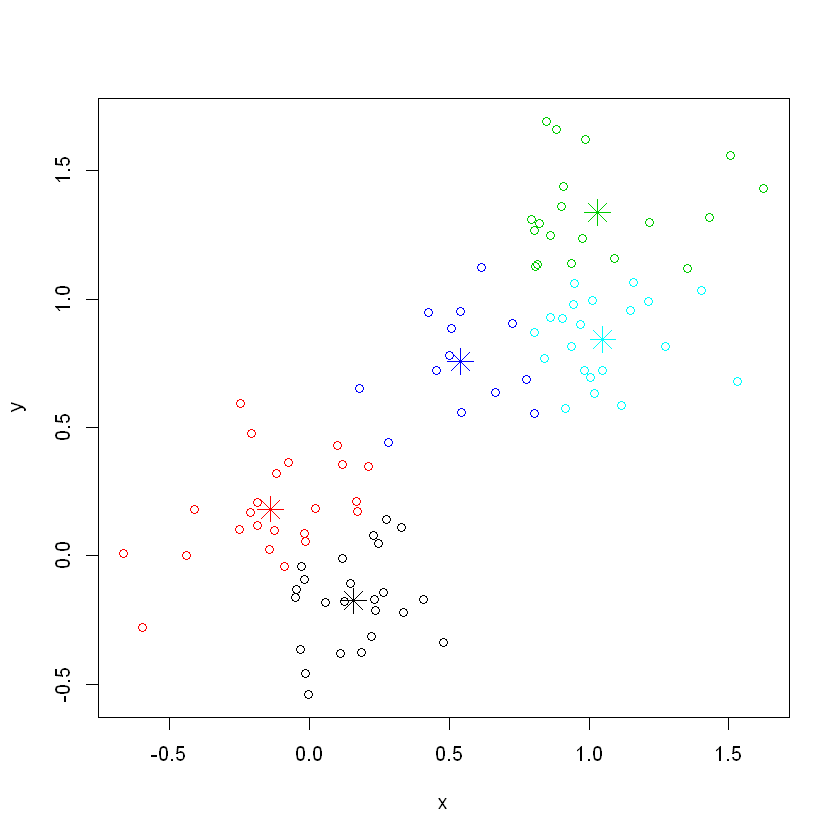

In [27]:
clusterPlot(X, n = 5, nstart = 25)

In [34]:
rxSetComputeContext(RxLocalParallel())

numTimes <- 8
results <- rxExec(kmeans, X, centers = 5, iter.max = 35, nstart = 50, timesToRun = numTimes, elemType = "cores")

(sumSSW <- vapply(results, function(x) sum(x$withinss), FUN.VALUE = numeric(1)))
results[[which.min(sumSSW)]]

[1] 7.062323 7.062323 7.062323 7.062323 7.062323 7.062323 7.062323 7.062323

K-means clustering with 5 clusters of sizes 25, 24, 12, 15, 24

Cluster means:
           x          y
1 -0.1096832  0.2106891
2  0.8043520  0.7805033
3  1.3290081  1.1185534
4  0.8609139  1.3145869
5  0.1581362 -0.1761590

Clustering vector:
  [1] 1 5 1 5 1 1 5 5 1 1 2 5 1 1 5 1 5 1 5 1 5 5 1 1 5 1 5 1 1 5 5 5 1 5 1 1 1
 [38] 5 5 5 5 1 1 1 1 1 5 5 5 5 4 2 2 2 2 3 3 3 2 3 4 2 3 4 2 4 2 2 3 4 4 3 4 2
 [75] 2 3 4 4 4 4 2 4 3 2 3 2 4 2 2 2 2 3 2 4 2 2 3 2 4 2

Within cluster sum of squares by cluster:
[1] 2.5330710 1.5056575 1.0314888 0.7104553 1.2816507
 (between_SS / total_SS =  88.4 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

In [38]:
kMeansRSR <- function(x, centers = 5, iter.max = 10, nstart = 1, numTimes = 20) {
  results <- rxExec(FUN = kmeans, x = x, centers = centers, iter.max = iter.max, 
                    nstart = nstart, elemType = "cores", timesToRun = numTimes)
  sumSSW <- vapply(results, function(x) sum(x$withinss), FUN.VALUE = numeric(1))
  results[[which.min(sumSSW)]]
}
                   
# create 5000 x 50 matrix
nrow <- 5000
ncol <- 50
Z <- matrix(rnorm(nrow*ncol), nrow, ncol)
iter.max <- 50
workers <- 8

nstart <- 32
(km1st <- system.time(km1 <- kmeans(Z, 10, iter.max, nstart)))
(km8st <- system.time(kmrsr <- kMeansRSR(Z, 10, iter.max, nstart = nstart/(2*workers), numTimes = 2*workers)))

   user  system elapsed 
   6.75    0.00    6.75 

   user  system elapsed 
   0.28    0.23   11.05 

## cross-validation with a parallel backend

In [37]:
airline.xdf <- file.path(output.path, "airline.xdf")

colClasses <- c(ArrDelay = "numeric", CRSDepTime = "numeric", DayOfWeek = "factor")
rxImport(airline.csv, airline.xdf, colClasses = colClasses, overwrite = TRUE, reportProgress = 0)

airline.scored.xdf <- file.path(output.path, "airline_scored.xdf")

k <- 10
rxDataStep(inData = airline.xdf,
           outFile = airline.xdf,
           transforms = list(
             kSplits = factor(sample(LETTERS[1:k], size = .rxNumRows, replace = TRUE))),
           transformObjects = list(LETTERS = LETTERS, k = k),
           append = "rows", 
           overwrite = FALSE, reportProgress = 0)

# split the data by each fold
kSplits <- rxSplit(inData = airline.xdf,
                   outFilesBase = file.path(output.path, "airline"),
                   splitByFactor = "kSplits", overwrite = TRUE, reportProgress = 0)

# for each fold:
# run `rxLinMod` on the other k-1 folds
# predict on the k-th fold based on the model developed above

myLinModWrapper <- function(
  holdoutlevel, # letters A-Z, one for each fold
  splitFiles, # a list of file names, one for each data split
  outFile = NULL # an optional data path, to combine all the splits into a single file
) {
  
  # first, estimate the model on all data point but those including holdoutlevel
  myMod <- rxLinMod(ArrDelay ~ DayOfWeek + F(CRSDepTime), data = airline.xdf,
                    rowSelection = kSplits != holdout,
                    transformObjects = list(holdout = holdoutlevel),
                    reportProgress = 0)
  
  # then, generate predictions
  curHoldOut <- grep(paste("kSplits", holdoutlevel, "xdf", sep = "."), names(splitFiles), value = TRUE)
  rxPredict(myMod, data = splitFiles[[curHoldOut]], overwrite = TRUE, predVarNames = "ArrDelay_kFold_Pred", reportProgress = 0)
  
 return(holdoutlevel)
}

# we can run this sequentially using `lapply`
system.time(lapply(LETTERS[1:k], myLinModWrapper, splitFiles = kSplits))

# we can run it sequentially using `rxExec`
rxSetComputeContext(RxLocalSeq())
system.time(rxExec(myLinModWrapper, splitFiles = kSplits, elemArgs = as.list(LETTERS[1:k])))

# we can run it in parallel using `rxExec`
rxSetComputeContext(RxLocalParallel())
system.time(rxExec(myLinModWrapper, splitFiles = kSplits, elemArgs = as.list(LETTERS[1:k]), execObjects = c('airline.xdf', 'airline.scored.xdf', 'output.path'), elemType = "cores"))

   user  system elapsed 
   1.22    0.07    2.77 

   user  system elapsed 
   1.17    0.01    2.64 

   user  system elapsed 
   0.03    0.05    7.30 